The times taken to query the base galaxy Table using obsMetadata and instance Catalogs is much larger than the time to query the galaxy table on fatboy directly. This records timeit results for these queries

## Setup

In [1]:
from __future__ import division, print_function, absolute_import

In [2]:
import time
import os
import pandas as pd
import numpy as np

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import seaborn as sns
sns.set()

/usr/local/manual/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
from lsst.sims.catalogs.measures.instance import InstanceCatalog
import lsst.sims.catUtils.baseCatalogModels as bcm
from lsst.sims.catalogs.generation.db import CatalogDBObject, DBObject
from lsst.sims.catUtils.baseCatalogModels.GalaxyModels import GalaxyTileObj, GalaxyObj
from lsst.sims.utils import ObservationMetaData

/Users/rbiswas/src/LSST/sims_catalogs_generation/python/lsst/sims/catalogs/generation/db/dbConnection.py:438: UserWarning: Duplicate object type id 25 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')
/Users/rbiswas/src/LSST/sims_catalogs_generation/python/lsst/sims/catalogs/generation/db/dbConnection.py:438: UserWarning: Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')


## Observation Meta Data

In [78]:
# Shifted to corner
observerMetaData_2 = ObservationMetaData(boundType='box',
                                  pointingRA=2.,
                                  pointingDec=2.,
                                  boundLength=1.)

In [79]:
# Shifted to corner
observerMetaData_1 = ObservationMetaData(boundType='box',
                                  pointingRA=2.,
                                  pointingDec=2.,
                                  boundLength=2.)

In [80]:
# Original Base
observerMetaData = ObservationMetaData(boundType='box',
                                  pointingRA=0.,
                                  pointingDec=0.,
                                  boundLength=2.)

In [106]:
# Shifted to corner
observerMetaData_3 = ObservationMetaData(boundType='box',
                                  pointingRA=2.,
                                  pointingDec=2.,
                                  boundLength=0.5)

In [107]:
observerMetaData.boundLength

2.0

In [124]:
def queryObsMetaData(obsMetaData):
    ra, dec, size = obsMetaData.pointingRA, obsMetaData.pointingDec, obsMetaData.boundLength
    raSize , decSize = (size, size)
    coords = np.asarray([ra - size, ra + size, dec - size, dec + size])
    
    coordTrans = np.remainder(coords + size, np.repeat(4., 4)) - size
    coordWraps =  np.floor_divide(coords[[1,3]] - coords[[0,2]] , (4,4))
    querylims = coordTrans[2], coordTrans[0], coordTrans[3], coordTrans[1]
    
    
    if coordTrans[2] < coordTrans[0]:
        print('split')
    if coordTrans[3] < coordTrans[1]:
        print('split')
        
    #bounds = [Polygon(vert, fill=False, lw=2, alpha=1., ls='dashed') for vert in verts]
    return coords, coordTrans, coordWraps, querylims


In [125]:
queryObsMetaData(observerMetaData)

(array([-2.,  2., -2.,  2.]),
 array([-2., -2., -2., -2.]),
 array([ 1.,  1.]),
 (-2.0, -2.0, -2.0, -2.0))

In [126]:
queryObsMetaData(observerMetaData_1)

(array([ 0.,  4.,  0.,  4.]),
 array([ 0.,  0.,  0.,  0.]),
 array([ 1.,  1.]),
 (0.0, 0.0, 0.0, 0.0))

In [127]:
queryObsMetaData(observerMetaData_2)

(array([ 1.,  3.,  1.,  3.]),
 array([ 1., -1.,  1., -1.]),
 array([ 0.,  0.]),
 (1.0, 1.0, -1.0, -1.0))

In [128]:
queryObsMetaData(observerMetaData_3)

(array([ 1.5,  2.5,  1.5,  2.5]),
 array([ 1.5,  2.5,  1.5,  2.5]),
 array([ 0.,  0.]),
 (1.5, 1.5, 2.5, 2.5))

In [129]:
queryObsMetaData(observerMetaData_3)

(array([ 1.5,  2.5,  1.5,  2.5]),
 array([ 1.5,  2.5,  1.5,  2.5]),
 array([ 0.,  0.]),
 (1.5, 1.5, 2.5, 2.5))

In [30]:
def tileObsMetaData(obsMetaData, num):
    ra, dec, size = obsMetaData.pointingRA, obsMetaData.pointingDec, obsMetaData.boundLength
    blen = size / num
    pras = np.arange(ra - size, ra + size, 2.0 *blen) + blen
    pdecs = np.arange(dec - size, dec + size, 2.0 * blen) + blen
    
    coords = np.dstack(np.meshgrid(pras, pdecs)).reshape(len(pras) * len(pdecs), 2)
    obsmdata = [ObservationMetaData(boundType='box',
                                  pointingRA=coords[i, 0],
                                  pointingDec=coords[i, 1],
                                  boundLength=blen) for i in range(len(coords))]
    # return coords
    diffvec = np.array([blen, blen])
    transvec = np.array([1, -1])
    verts = [[coord - diffvec, coord - transvec * diffvec, coord + diffvec, coord + diffvec *transvec] for coord in coords]  
    bounds = [Polygon(vert, fill=False, lw=2, alpha=1., ls='dashed') for vert in verts]
    return obsmdata, coords, bounds



(-2.0, 2.0)

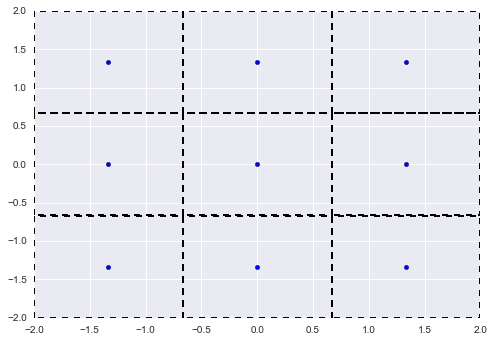

In [31]:
tiledObsMD, coords, bounds = tileObsMetaData(observerMetaData, 3)
fig, ax =plt.subplots()
ax.scatter(coords[:,0], coords[:, 1])
for bound in bounds:
    ax.add_patch(bound)
ax.set_xlim(-2., 2.)
ax.set_ylim(-2., 2.)

In [ ]:
len(tiledObsMD)

In [ ]:
class galCopy(InstanceCatalog):
    column_outputs = ['galtileid', 'raJ2000', 'decJ2000', 'redshift']#, 'a_d', 'b_d', 'pa_disk', 'mass_stellar', 'absmag_r_total']
    override_formats = {'raJ2000': '%8e', 'decJ2000': '%8e', 'a_d': '%8e', 'b_d': '%8e', 'pa_disk': '%8e', 
                        'mass_stellar': '%8e', 'absmag_r_total': '%8e'}

In [ ]:
def writeCat(obsMD=tiledObsMD, redshiftmax=0.4, fname='gB-test', chunkSize=None):
    constr = 'redshift < {0}'.format(redshiftmax)
    galaxyTiled = GalaxyTileObj()
    print(len(obsMD))
    filenames = []
    for i, obsMetaData in enumerate(obsMD):
        filename = fname  + '{}'.format(i) + '.csv'
        filenames.append(filename)
        galaxyBase = galCopy(galaxyTiled, obs_metadata=obsMetaData, constraint=constr)
        galaxyBase.write_catalog(filename, chunkSize)
    return filenames

In [ ]:
# No need
def writeCatBase(redshiftmax=0.4, fname='gB-test.csv', chunkSize=None):
    constr = 'redshift < {0}'.format(redshiftmax)
    galaxyTiled = GalaxyObj()
    galaxyBase = galBaseCopy(galaxyTiled, obs_metadata=obsMetaData, constraint=constr)
    galaxyBase.write_catalog(fname, chunkSize)

In [ ]:
tileObsMD, coords, bounds = tileObsMetaData(observerMetaData, 1)

In [ ]:
len(tileObsMD)

In [ ]:
%%timeit
chunksize = None
tstart = time.time()
fnames = writeCat(obsMD=tileObsMD, chunkSize=chunksize)
print(fnames)
tend = time.time()
print(tend - tstart)
numlines = 0

In [ ]:
tileObsMD, coords, bounds = tileObsMetaData(observerMetaData, 2)

In [ ]:
%%timeit
chunksize = None
tstart = time.time()
fnames = writeCat(obsMD=tileObsMD, chunkSize=chunksize)
print(fnames)
tend = time.time()
print(tend - tstart)
numlines = 0

In [ ]:
tileObsMD, coords, bounds = tileObsMetaData(observerMetaData, 3)

In [ ]:
%%timeit
chunksize = None
tstart = time.time()
fnames = writeCat(obsMD=tileObsMD, chunkSize=chunksize)
print(fnames)
tend = time.time()
print(tend - tstart)
numlines = 0

In [ ]:
query = """EXECUTE [LSSTCATSIM].[dbo].[GalaxySearch2015l]
                   @ApertureStr = 'REGION RECT J2000 358.000000 -2.000000 2.000000 2.000000', @ColumnNames = 'dec as decJ2000,ra as raJ2000,redshift as redshift',
                   @ComponentSubset = 'ALL' , @WhereClause = 'redshift < 0.4’
        """


In [ ]:
numLines = 1
for i in range(9):
    fname = "gB-test{}.csv".format(i)
    with open(fname, 'r') as fp:
        numLines += sum(1 for line in fp) - 1 

In [ ]:
print(numLines)

In [ ]:
!tail gB-test0.csv

In [ ]:
!wc -l *.csv

In [ ]:
def writeDBObjBase(redshiftmax=0.4, fname='gB-test.csv', chunkSize=None):
    constr = 'redshift < {0}'.format(redshiftmax)
    galaxyBase = GalaxyTileObj()
    # galDB = dbobject = DBObject(database=config.database, driver='mssql+pymssql', host=config.host, port=config.port, connection=None)
    #galaxyBase = galBaseCopy(galaxyTiled, obs_metadata=obsMetaData, constraint=constr)
    query = """SELECT galtileid, raJ2000, decJ2000, redshift FROM galaxy WHERE redshift < 0.4 AND raJ2000 < 2 and raJ2000 > -2 and decJ2000 < 2 and decJ2000 > -2"""
    x = galaxyBase.execute_arbitrary(query)
    print(len(x), len(x[0]))
    #galaxyBase.write_catalog(fname, chunkSize)

In [ ]:
def writeDBObjBase(redshiftmax=0.4, fname='gB-test.csv', chunkSize=None):
    constr = 'redshift < {0}'.format(redshiftmax)
    galaxyBase = GalaxyObj()
    # galDB = dbobject = DBObject(database=config.database, driver='mssql+pymssql', host=config.host, port=config.port, connection=None)
    #galaxyBase = galBaseCopy(galaxyTiled, obs_metadata=obsMetaData, constraint=constr)
    query = """SELECT id, ra, dec, redshift WHERE redshift < 0.4 AND ra < 2 and ra > -2 and dec < 2 and dec > -2"""
    x = galaxyBase.execute_arbitrary(query)
    print(len(x), len(x[0]))
    #galaxyBase.write_catalog(fname, chunkSize)

In [ ]:
%%timeit
chunksize = None
tstart = time.time()
writeDBObjBase(chunkSize=chunksize)
tend = time.time()
print(tend - tstart)

In [ ]:
%%timeit
chunksize = None
tstart = time.time()
writeCat(chunkSize=chunksize)
tend = time.time()
print(tend - tstart)

In [ ]:
%%timeit
chunksize = 50000
tstart = time.time()
writeCat(chunkSize=chunksize)
tend = time.time()
print(tend - tstart)

In [ ]:
%%timeit
chunksize = 500000
tstart = time.time()
writeCat(chunkSize=chunksize)
tend = time.time()
print(tend - tstart)

In [ ]:
%%timeit
chunksize = 5000
tstart = time.time()
writeCat(chunkSize=chunksize)
tend = time.time()
print(tend - tstart)

In [ ]:
%%timeit
chunksize = 50
tstart = time.time()
writeCat(chunkSize=chunksize)
tend = time.time()
print(tend - tstart)

In [ ]:
# No need
class galBaseCopy(InstanceCatalog):
    column_outputs = ['id', 'raJ2000', 'decJ2000', 'redshift']#, 'a_d', 'b_d', 'pa_disk', 'mass_stellar', 'absmag_r_total']
    override_formats = {'raJ2000': '%8e', 'decJ2000': '%8e', 'a_d': '%8e', 'b_d': '%8e', 'pa_disk': '%8e', 
                        'mass_stellar': '%8e', 'absmag_r_total': '%8e'}

## Direct query with fetch

In [7]:
from lsst.utils import getPackageDir
from lsst.daf.persistence import DbAuth
import lsst.pex.config as pexConfig
import pymssql

In [ ]:
def build_queries(obsMetaData):
    
    

In [23]:
%%timeit
tstart = time.time()
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)
db = DBConnection.cursor()
query = """SELECT id, ra, dec, redshift FROM galaxy WHERE redshift < 1.4 AND ra < 2 and ra > -2 and dec < 2 and dec > -2"""
db.execute(query)
x = db.fetchall()
print(len(x), len(x[0]))
tend = time.time()
print(tend - tstart)

7158432 4
26.2782211304
7158432 4
26.472784996
7158432 4
27.5812399387
7158432 4
25.6039869785
1 loops, best of 3: 25.6 s per loop


In [15]:
%%timeit
tstart = time.time()
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)
db = DBConnection.cursor()
query = """SELECT id, ra, dec, redshift FROM galaxy WHERE redshift < 0.4 AND ra < 1 and ra > 0 and dec < 1 and dec > 0"""
db.execute(query)
x = db.fetchall()
print(len(x), len(x[0]))
tend = time.time()
print((tend - tstart) * 16.)

56924 4
14.428352356
56924 4
12.6928939819
56924 4
12.1693763733
56924 4
13.5419692993
1 loops, best of 3: 761 ms per loop


In [ ]:
%%timeit

tstart = time.time()
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)
db = DBConnection.cursor()
query = """SELECT id, ra, dec, redshift FROM galaxy WHERE redshift < 0.4 AND ra < 2 and ra > -2 and dec < 2 and dec > -2"""
db.execute(query)
x = db.fetchall()
print(len(x), len(x[0]))
tend = time.time()
print(tend - tstart)

In [17]:
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)



In [22]:
%%timeit

tstart = time.time()
db = DBConnection.cursor()
query = """SELECT id, ra, dec, redshift FROM galaxy WHERE redshift < 1.4 AND ra < 1 and ra > -0 and dec < 1 and dec > -0"""
db.execute(query)
x = db.fetchall()
print(len(x), len(x[0]))
tend = time.time()
print(16.0*(tend - tstart))

453911 4
39.7260627747
453911 4
46.1514549255
453911 4
38.8499031067
453911 4
38.8650894165
1 loops, best of 3: 2.43 s per loop


In [ ]:
%%timeit
tstart = time.time()
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)
db = DBConnection.cursor()
query = """SELECT id, ra, dec, redshift FROM galaxy WHERE redshift < 0.4 AND ra < 2 and ra > -2 and dec < 2 and dec > -2"""
db.execute(query)
x = db.fetchall()
print(len(x), len(x[0]))
tend = time.time()
print(tend - tstart)

In [ ]:
%%timeit
tstart = time.time()
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)
db = DBConnection.cursor()
query = """EXECUTE [LSSTCATSIM].[dbo].[GalaxySearch2015]
                   @ApertureStr = 'REGION RECT J2000 358.000000 -2.000000 2.000000 2.000000', @ColumnNames = 'dec as decJ2000,ra as raJ2000,redshift as redshift',
                   @ComponentSubset = 'ALL' , @WhereClause = 'redshift < 0.4'
"""
db.execute(query)
x = db.fetchall()
print(len(x), len(x[0]))
tend = time.time()
print(tend - tstart)

In [ ]:
%%timeit
tstart = time.time()
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)
db = DBConnection.cursor()
query = """[LSSTCATSIM].[dbo].[GalaxySearch2015]
                   @ApertureStr = 'REGION RECT J2000 358.000000 -2.000000 2.000000 2.000000', @ColumnNames = 'dec as decJ2000,ra as raJ2000,redshift as redshift',
                   @ComponentSubset = 'ALL' , @WhereClause = 'redshift < 0.4'"""

db.execute(query)
x = db.fetchall()
print(len(x), len(x[0]))
tend = time.time()
print(tend - tstart)

In [ ]:
%%timeit
tstart = time.time()
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)
db = DBConnection.cursor()
query = """SELECT id, ra, dec, redshift FROM galaxy WHERE redshift < 0.4 AND ra < 2 and ra > -2 and dec < 2 and dec > -2"""
db.execute(query)
num = 50000
x = db.fetchmany(num)
while len(x)>0:
    x = db.fetchmany(num)
# print(len(x), len(x[0]))
tend = time.time()
print(tend - tstart)

In [ ]:
!pwd

In [ ]:
%%timeit
tstart = time.time()
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)
db = DBConnection.cursor()
query = """SELECT id, ra, dec, redshift FROM galaxy WHERE redshift < 0.4 AND ra < 2 and ra > -2 and dec < 2 and dec > -2"""
db.execute(query)
#num = 50000
x = db.fetchall()
# print(len(x), len(x[0]))
tend = time.time()
print(tend - tstart)

In [ ]:
%%timeit
tstart = time.time()
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)
db = DBConnection.cursor()
query = """SELECT id, ra, dec, redshift FROM galaxy WHERE redshift < 0.4 AND ra < 2 and ra > -2 and dec < 2 and dec > -2"""
db.execute(query)
num = 50000
x = db.fetchmany(num)
while len(x) > 0:
    x = db.fetchmany(num)
# print(len(x), len(x[0]))
#df = pd.DataFrame.from_records(x, columns=['id', 'ra', 'dec', 'redshift'])
#df.to_csv('gb_pd.test.csv', index=False)
tend = time.time()
print(tend - tstart)

In [ ]:
%%timeit
tstart = time.time()
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)
db = DBConnection.cursor()
query = """SELECT id, ra, dec, redshift FROM galaxy WHERE redshift < 0.4 AND ra < 2 and ra > -2 and dec < 2 and dec > -2"""
db.execute(query)
#num = 50000
x = db.fetchall()
# print(len(x), len(x[0]))
df = pd.DataFrame.from_records(x, columns=['id', 'ra', 'dec', 'redshift'])
df.to_csv('gb_pd.test.csv', index=False)
tend = time.time()
print(tend - tstart)

In [ ]:
%%timeit
tstart = time.time()
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)
db = DBConnection.cursor()
query = """SELECT id, ra, dec, redshift FROM galaxy WHERE redshift < 0.4 AND ra < 2 and ra > -2 and dec < 2 and dec > -2"""
db.execute(query)
#num = 50000
x = db.fetchall()
# print(len(x), len(x[0]))
df = pd.DataFrame.from_records(x, columns=['id', 'ra', 'dec', 'redshift'])
df.to_csv('gb_pd.test.csv', index=False)
tend = time.time()
print(tend - tstart)

In [ ]:
%%timeit
tstart = time.time()
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)
db = DBConnection.cursor()
query = """SELECT galaxy.id AS id, ra*PI()/180. AS [raJ2000], dec*PI()/180. AS [decJ2000], galaxy.redshift AS redshift 
FROM galaxy  WITH(FORCESEEK) JOIN (SELECT htmidstart, htmidend 
FROM fHtmCoverRegion(%(fHtmCoverRegion_1)s)) AS anon_1 ON galaxy.htmid BETWEEN anon_1.htmidstart AND anon_1.htmidend 
WHERE sph.fRegionContainsXYZ(sph.fSimplifyString(%(fSimplifyString_1)s), galaxy.cx, galaxy.cy, galaxy.cz) = %(fRegionContainsXYZ_1)s
"""
db.execute(query)
#num = 50000
x = db.fetchall()
# print(len(x), len(x[0]))
df = pd.DataFrame.from_records(x, columns=['id', 'ra', 'dec', 'redshift'])
df.to_csv('gb_pd.test.csv', index=False)
tend = time.time()
print(tend - tstart)

In [ ]:
config = bcm.BaseCatalogConfig()
config.load(os.path.join(getPackageDir("sims_catUtils"), "config", "db.py"))
DBConnection = pymssql.connect(user=DbAuth.username(config.host, config.port),
                               password=DbAuth.password(config.host, config.port),
                               database=config.database, port=config.port)



In [ ]:
config

In [ ]:
dbobject = DBObject(database=config.database, driver='mssql+pymssql', host=config.host, port=config.port, connection=None)

In [ ]:
dbobject.execute_arbitrary()

In [6]:
deltaAng =  np.radians(2)

In [90]:
coords = np.random.uniform((- deltaAng, -deltaAng), (deltaAng, deltaAng), size=(10e6, 2))

/usr/local/manual/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


In [91]:
df = pd.DataFrame(coords, columns=['theta', 'phi'])

In [92]:
df.describe()

,theta,phi
count,1.000000e+07,10000000.000000
mean,6.918292e-08,0.000005
std,2.015738e-02,0.020155
min,-3.490657e-02,-0.034907
25%,-1.746115e-02,-0.017448
50%,2.639225e-06,0.000005
75%,1.745630e-02,0.017466
max,3.490658e-02,0.034907


In [137]:
def rotated(df, delta=0.):
    cosDelta = np.cos(delta)
    sinDelta = np.sin(delta)
    sintheta = np.sin(df.theta)
    costheta = np.cos(df.theta)
    cosphi = np.cos(df.phi)
    costhetaprime =  costheta * cosDelta - sinDelta * sintheta * cosphi
    sinthetaprime = np.sqrt(1.0 - costhetaprime**2.) * np.sign(df.theta)
    cosphiprime = (sintheta * cosphi * cosDelta + costheta * sinDelta ) /sinthetaprime
    df['costhetprime']= costhetaprime
    df['cosphiprime'] = cosphiprime
    df['thetaprime'] = np.arcsin(sinthetaprime)
    df['phiprime'] = np.arccos(cosphiprime) * np.sign(df.phi)

In [147]:
rotated(df, delta=deltaAng*2.*3)

In [148]:
df.head()

,theta,phi,thetaprime,phiprime,costhetprime,cosphiprime
0,0.013656,0.007796,0.223095,0.000481,0.975217,1.000000
1,-0.000172,-0.015834,-0.209268,-3.141580,0.978183,-1.000000
2,0.015505,-0.012049,0.224943,-0.000837,0.974807,1.000000
3,-0.005364,0.006819,-0.204075,3.141412,0.979249,-1.000000
4,0.023667,0.012265,0.233104,0.001256,0.972954,0.999999


In [149]:
df_a = df.ix[np.random.random_integers(0, len(df), size=10000)]
df_b = df.ix[np.random.random_integers(0, len(df), size=10000)]

In [150]:
df_a.head()

,theta,phi,thetaprime,phiprime,costhetprime,cosphiprime
8169303,0.011295,-0.033140,0.220728,-0.001709,0.975738,0.999999
4038307,-0.019061,-0.015319,-0.190381,-3.140050,0.981932,-0.999999
1228795,-0.030010,-0.009333,-0.179431,-3.140024,0.983945,-0.999999
6788177,-0.028556,-0.014002,-0.180887,-3.139370,0.983685,-0.999998
8668931,-0.020928,0.031974,-0.188523,3.138023,0.982282,-0.999994


In [151]:
df.ix[1]

theta          -0.000172
phi            -0.015834
thetaprime     -0.209268
phiprime       -3.141580
costhetprime    0.978183
cosphiprime    -1.000000
Name: 1, dtype: float64

In [152]:
def angSep( df1, df2, theta, phi):
    th1 = df1[theta].values
    th2 = df2[theta].values
    ph1 = df1[phi].values
    ph2 = df2[phi].values

    cos = np.sin(th1)* np.sin(th2)* np.cos(ph1- ph2) + np.cos(th1)*np.cos(th2)
    return cos

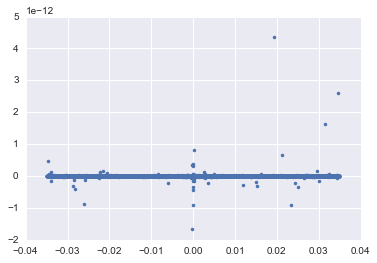

In [154]:
plt.plot(df_a['theta'] , 
         angSep(df_a, df_b, 'theta', 'phi')- angSep(df_a, df_b, 'thetaprime', 'phiprime'),'.')

In [167]:
x = angSep(df_a, df_b, 'theta', 'phi')- angSep(df_a, df_b, 'thetaprime', 'phiprime')

In [170]:
x

array([False, False, False, ..., False, False, False], dtype=bool)

In [160]:
np.max(x)

nan

In [164]:
len(x[np.isnan(x)])

1

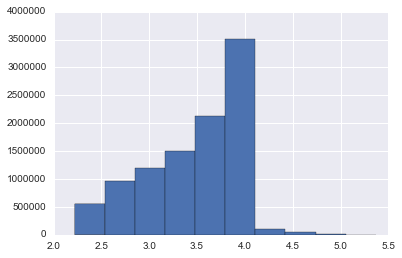

In [44]:
(df.thetaprime - df.theta).apply(np.degrees).hist()

In [51]:
df.theta.describe()

count    10000000.000000
mean            0.482313
std             0.298839
min            -0.034907
25%             0.223323
50%             0.482206
75%             0.741157
max             1.000000
Name: theta, dtype: float64

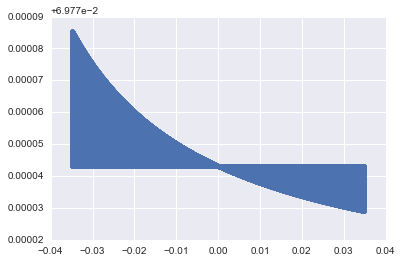

In [62]:
plt.plot(df.theta.astype(np.float).values, df.thetaprime.astype(np.float).values - df.theta.astype(np.float).values, '.')

In [61]:
%timeit rotated(df, delta=2*deltaAng)

1 loops, best of 3: 993 ms per loop


In [37]:
len(df.theta)/1.0e6

10.0

In [31]:
x = rotated(df, delta=2*deltaAng) - df.theta.values

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

(array([   74411.,    77435.,    80472.,    73698.,    31837.,        0.,
               0.,   228993.,  2615518.,  6817636.]),
 array([ -3.99999365e+00,  -3.19999431e+00,  -2.39999497e+00,
         -1.59999562e+00,  -7.99996282e-01,   3.06095169e-06,
          8.00002403e-01,   1.60000175e+00,   2.40000109e+00,
          3.20000043e+00,   3.99999977e+00]),
 <a list of 10 Patch objects>)

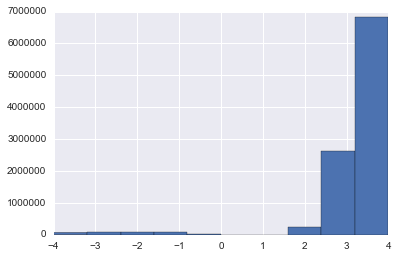

In [33]:
plt.hist(np.degrees(x))